### OpenCV face recognition
- Detect, transform and crop
- DNN
- Representation (128 length embedding) with [FaceNet](https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/1A_089.pdf)
  - Clustering
  - Similarity
  - Classification
- Face Alignment and crop (optional, but helps the FaceNet model)
- training: triplet loss function (anchor is the current face, positive also contains same face, negative doesn't have same identity)
- learning: try to minimize error between anchor and positive embeddings, try to maximize rror between anchor and negative

---

### [Used Dataset from Roboflow](https://universe.roboflow.com/uas-machine-learning-object-detection/face-recognition-qqdaa/dataset/1)


## Imports

In [98]:
import imutils
import cv2 as cv
import sys
import os
import numpy as np
import pickle

In [99]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

In [100]:
print(cv.__version__)

4.12.0


## Load embedder and detector

In [101]:
proto_path = 'deploy.prototxt'
model_path = 'res10_300x300_ssd_iter_140000.caffemodel'

detector = cv.dnn.readNetFromCaffe(proto_path, model_path)
detector

< cv2.dnn.Net 0x71674000aa10>

In [102]:
embedding_model_path = 'openface.nn4.small2.v1.t7'
embedder = cv.dnn.readNetFromTorch(embedding_model_path)
embedder

< cv2.dnn.Net 0x71674c9d3890>

## Image Paths

In [103]:
dataset_path = 'dataset/train/'
names = os.listdir(dataset_path)

list_images_train = []
for name in names:
  person_dir = os.path.join(dataset_path, name)
  for filename in os.listdir(person_dir):
    list_images_train.append(str(name + '/' + filename))

len(list_images_train)#, list_images_train[:10], list_images_train[2054:]

2065

## Process images and create embeddings

In [104]:
known_embedd = []
known_name = []

for (i, image_path) in enumerate(list_images_train):
  image = cv.imread(os.path.join(dataset_path, image_path))
  if image is None:
    continue
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]

  image_blob = cv.dnn.blobFromImage( cv.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=False, crop=False )
  detector.setInput(image_blob)
  detections = detector.forward()

  i = np.argmax(detections[0, 0, :, 2])
  confidence = detections[0, 0, i, 2]

  if confidence > 0.5:
    # compute the (x, y) coordinates of the bounding box for the face
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # extract the face ROI and grab the ROI dimensions
    face = image[startY:endY, startX:endX]
    (fH, fW) = face.shape[:2]

    if fW < 20 or fH < 20:
      continue  # skip invalid images

    # construct a blob for the face ROI, then pass the blob through our face embedding model to obtain the 128-d quantification of the face
    faceBlob = cv.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
    embedder.setInput(faceBlob)
    vec = embedder.forward()

    known_embedd.append(vec.flatten())
    known_name.append(image_path.split('/')[0])

In [109]:
len(known_embedd), len(known_name)

(83, 83)

### Saving embeddings

In [105]:
embeddings = os.path.join('output/embeddings.pickle')
f = open(embeddings, 'wb')
f.write(pickle.dumps(known_embedd))
f.close()

## Train face recognition model

In [106]:
# load embeddings
data = pickle.loads(open(embeddings, 'rb').read())
data

[array([ 6.59510791e-02,  3.57284769e-02, -1.53347448e-01, -1.84787228e-03,
        -1.42317843e-02,  3.13305259e-02,  5.19196242e-02,  6.33561835e-02,
        -1.00543462e-01,  1.09729953e-01,  2.26254910e-02,  1.70459792e-01,
         5.16285375e-02, -3.03103253e-02, -9.90036726e-02,  7.51788635e-03,
         1.63848072e-01, -1.70080438e-02,  2.31268108e-02,  1.15847796e-01,
        -6.14634417e-02, -1.86727438e-02,  3.54505293e-02,  9.76910219e-02,
        -1.19932353e-01,  1.24688007e-01,  1.29198998e-01, -6.45692796e-02,
        -3.39828469e-02,  4.57316227e-02, -1.90832689e-01,  5.23348786e-02,
         9.50482190e-02,  7.00349659e-02, -1.40868887e-01, -9.73589644e-02,
         4.95128036e-02,  1.89653113e-01, -1.04631089e-01,  4.28823046e-02,
        -4.82637398e-02,  6.08618418e-03,  7.64534948e-03,  2.60427669e-02,
        -1.23407908e-01,  1.77215114e-02,  1.18402585e-01, -1.15354292e-01,
        -8.83720890e-02,  1.12093404e-01,  2.25202680e-01,  7.38017552e-04,
        -1.1

In [114]:
data[0].shape

(128,)

In [111]:
# label encoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(known_name)

for i in zip(labels, set(known_name)):
  print(i)

(np.int64(1), 'Claire Holt')
(np.int64(1), 'Billie Eilish')
(np.int64(1), 'Zac Efron')
(np.int64(1), 'Alexandra Daddario')


In [142]:
recognizer_model = SVC(C=2.0, kernel="linear", probability=True)
recognizer_model.fit(data, labels)

SVC(C=2.0, kernel='linear', probability=True)

## Testing

Now we have a three steps face recognition model:

1. Detect the faces (detector)
2. Create the embedding for the face (embedder)
3. Recognize the person (recognizer_model)
    - input is an embedding, the output is the labeled person's name

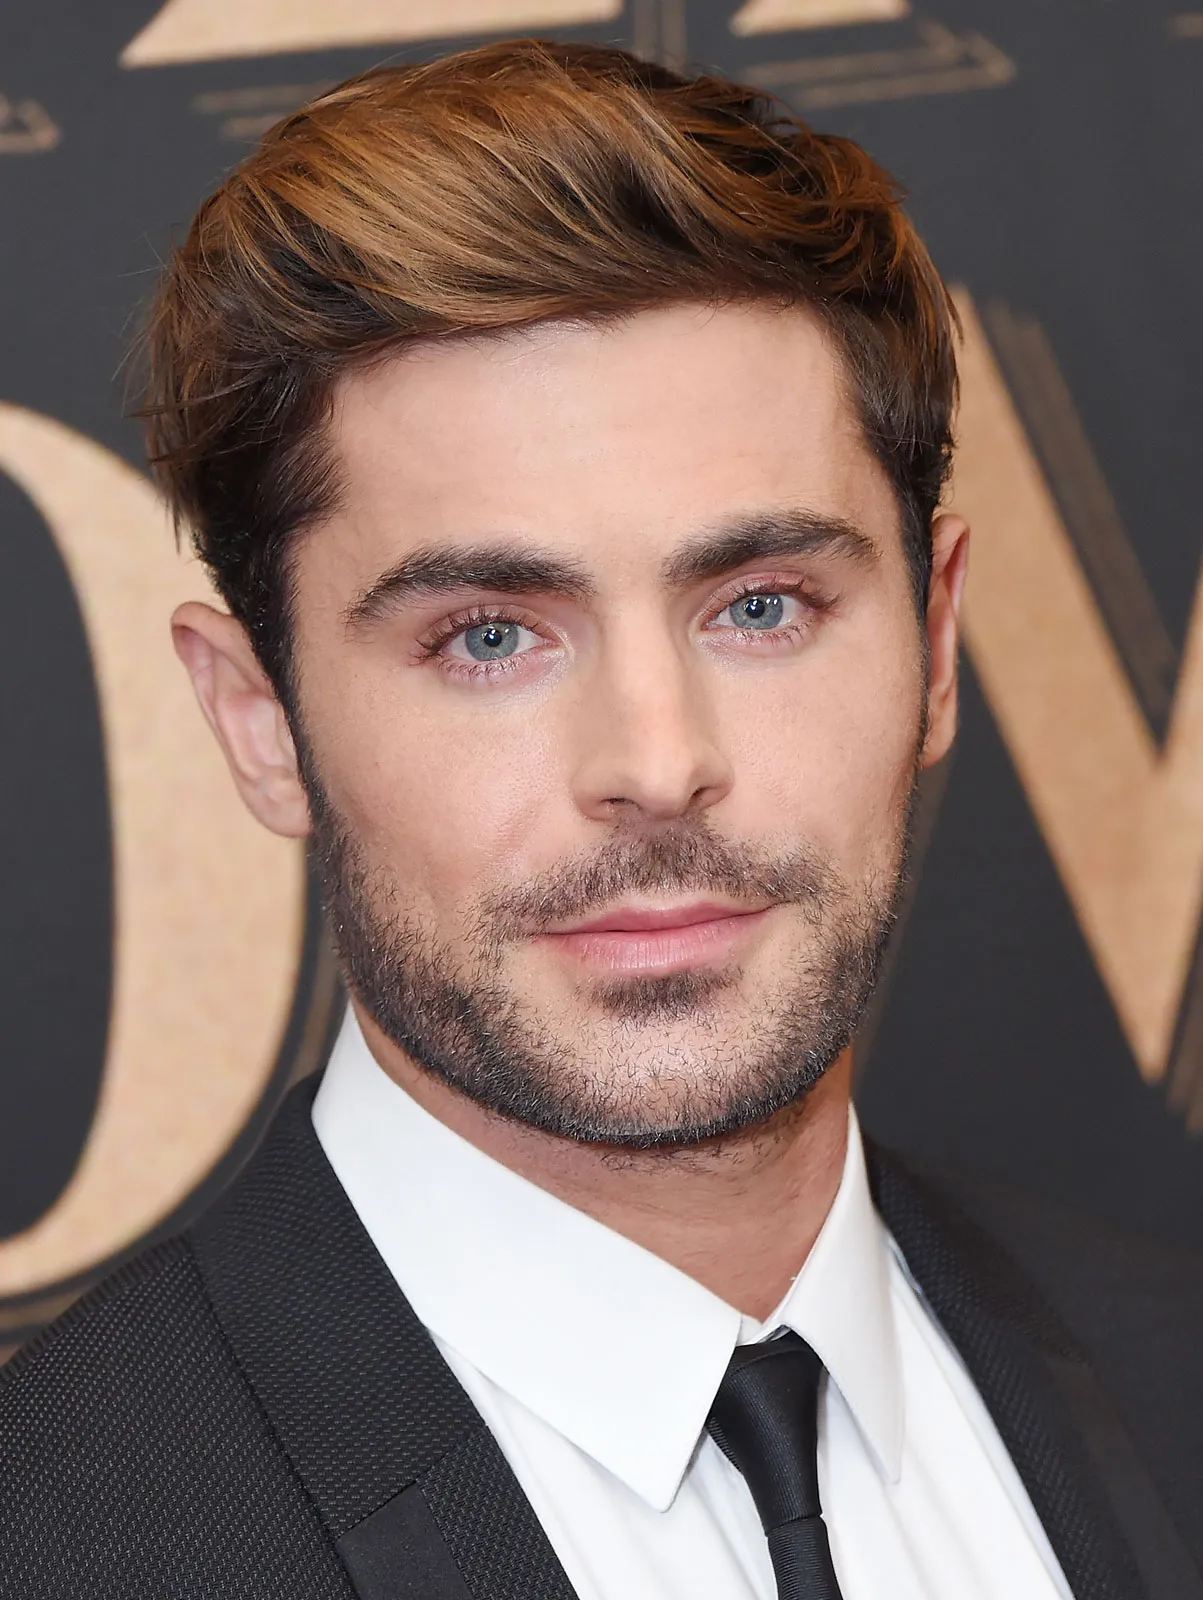

In [134]:
from PIL import Image
from IPython.display import display

# original image
im = Image.open("test-zac-efron.webp")
display(im)

In [115]:
test_img = cv.imread('test-zac-efron.webp')
test_img

array([[[74, 66, 68],
        [74, 66, 68],
        [74, 66, 68],
        ...,
        [66, 61, 62],
        [66, 61, 62],
        [65, 60, 61]],

       [[74, 66, 68],
        [74, 66, 68],
        [74, 66, 68],
        ...,
        [66, 61, 62],
        [66, 61, 62],
        [65, 60, 61]],

       [[74, 66, 68],
        [74, 66, 68],
        [74, 66, 68],
        ...,
        [66, 61, 62],
        [66, 61, 62],
        [65, 60, 61]],

       ...,

       [[28, 24, 24],
        [35, 31, 31],
        [53, 48, 49],
        ...,
        [53, 50, 53],
        [53, 50, 53],
        [53, 50, 53]],

       [[35, 31, 31],
        [53, 48, 49],
        [59, 54, 55],
        ...,
        [53, 50, 53],
        [53, 50, 53],
        [53, 50, 53]],

       [[58, 53, 54],
        [61, 56, 57],
        [47, 42, 43],
        ...,
        [53, 50, 53],
        [53, 50, 53],
        [53, 50, 53]]], shape=(1600, 1203, 3), dtype=uint8)

In [143]:
test_img = imutils.resize(test_img, width=600)
(h, w) = test_img.shape[:2]

test_imgBlob = cv.dnn.blobFromImage( cv.resize(test_img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=False, crop=False )

detector.setInput(test_imgBlob)
detections = detector.forward()

In [144]:
faceBlob = None

for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]
		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue
		
		faceBlob = cv.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
			(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()
		# perform classification to recognize the face
		preds = recognizer_model.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = label_encoder.classes_[j]

In [145]:
name

np.str_('Zac Efron')

### With test dataset images

In [146]:
dataset_path = 'dataset/test/'
names = os.listdir(dataset_path)

list_images_test = []
for name in names:
  person_dir = os.path.join(dataset_path, name)
  for filename in os.listdir(person_dir):
    list_images_test.append(str(name + '/' + filename))

for (i, image_path) in enumerate(list_images_test):
  image = cv.imread(os.path.join(dataset_path, image_path))
  if image is None:
    continue
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]

  image_blob = cv.dnn.blobFromImage( cv.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=False, crop=False )
  detector.setInput(image_blob)
  detections = detector.forward()

  i = np.argmax(detections[0, 0, :, 2])
  confidence = detections[0, 0, i, 2]

  if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box for the face
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
		# extract the face ROI
    face = image[startY:endY, startX:endX]
    (fH, fW) = face.shape[:2]
		# ensure the face width and height are sufficiently large
    if fW < 20 or fH < 20:
      continue
		
    faceBlob = cv.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
			(0, 0, 0), swapRB=True, crop=False)
    embedder.setInput(faceBlob)
    vec = embedder.forward()
		# perform classification to recognize the face
    preds = recognizer_model.predict_proba(vec)[0]
    j = np.argmax(preds)
    proba = preds[j]
    name = label_encoder.classes_[j]
    print(image_path)
    print(name, end='\n\n')

Alexandra Daddario/Alexandra-Daddario_100_jpeg.rf.a65ed4146741cdf1668edcbc9a39d171.jpg
Billie Eilish

Zac Efron/Zac-Efron_95_jpg.rf.693426d6de5c0754ce978b85e2b19081.jpg
Zac Efron

Zac Efron/Zac-Efron_93_jpg.rf.5baf2de3542ba54ecac59f8c46db9caf.jpg
Zac Efron

Claire Holt/Claire-Holt_97_jpg.rf.d7b75245e63f3d0485591ca0fad246f0.jpg
Claire Holt

Claire Holt/Claire-Holt_-04_jpg.rf.1cdd1be35c57c276a10873172a14417d.jpg
Zac Efron

Claire Holt/Claire-Holt_99_jpg.rf.ff96c5a0deef18d2b79d83ff35b7ea17.jpg
Claire Holt

